In [48]:
# imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import der Basisdaten

### HIER MÜSSEN WIR NOCH EINMAL FESTHALTEN WOHER UNSERE DATEN KOMMEN UND DAS SAUBER AUFLISTEN

### PV-Daten: Renewables.Ninja
Basierend auf Europäischem Datenset:CM-SAF SARAH (Europe) hohe Genauigkeit, da Angabe aus (lon/lat) -> VLH = 1072

### Temperaturdaten: DWD open database
Basierend auf historischen Daten für das Jahr 2022 der Wetterstation am Flughafen Köln/Bonn (ca. 12km Luftlinie)
-> Kälteanomalie im Dezember: kurzzeitig Temperaturen bis -10-Grad

In [49]:
# data imports
df_data = pd.read_csv("data/Modellierung_SoSe23.csv", sep=";", decimal=",", usecols=[0,1,4])

# load pv_data
pv_data = pd.read_csv("data/ninja_pv_50.8263_6.9721.csv", decimal=".", header=3)

# load and prepare temp data
temp_data = pd.read_csv("data/DWD_wetterdaten_KoelnBonn_Flughafen.txt", sep=";", decimal=".", usecols=[1,3])
temp_data = temp_data[(temp_data['MESS_DATUM'] >= 2022010100) & (temp_data['MESS_DATUM'] < 2023010101)]

# fill dataframe
df_data['pv'] = pv_data['electricity'].to_numpy()
df_data['temp'] = temp_data['TT_TU'].to_numpy()

df_data

,Zeit,electric_load,heat_load,pv,temp
0,01.01. 00:00,0.016247,0.22,0.0,12.6
1,01.01. 01:00,0.016162,0.13,0.0,13.0
2,01.01. 02:00,0.016005,0.07,0.0,12.6
3,01.01. 03:00,0.166450,0.03,0.0,12.2
4,01.01. 04:00,0.016200,0.07,0.0,12.8
...,...,...,...,...,...
8755,31.12. 19:00,1.107500,1.69,0.0,15.1
8756,31.12. 20:00,0.261240,1.73,0.0,15.9
8757,31.12. 21:00,0.289830,1.33,0.0,15.9
8758,31.12. 22:00,0.340810,0.81,0.0,15.6


In [50]:
# calculation and data preparation for heat_pump(wp)

# scraped data
wp_data = {
    "temp" : [-22, -15, -7, 2, 7, 10, 12, 20, 25, 30, 35],
    "heating_power" : [0, 25.50, 35.20, 43.00, 56.40, 60.30, 62.90, 67.30, 70.40, 73.60, 76.70],
    "el_power" : [0, 14.58, 15.54, 16.70, 18.54, 18.87, 18.87, 19.05, 19.13, 19.36, 19.46],
    "cop" : [0, 1.7, 2.3, 2.6, 3.0, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]
}

# assumptions
wp_el_p_nom = 12.5  # kW

# calculate COP
df_data["wp_COP_interp"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["cop"]),3)
df_data["wp_power_consumption"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["el_power"]),2)
df_data['wp_power_cons_norm'] = df_data["wp_power_consumption"] / wp_el_p_nom

df_data

,Zeit,electric_load,heat_load,pv,temp,wp_COP_interp,wp_power_consumption,wp_power_cons_norm
0,01.01. 00:00,0.016247,0.22,0.0,12.6,3.315,18.88,1.5104
1,01.01. 01:00,0.016162,0.13,0.0,13.0,3.325,18.89,1.5112
2,01.01. 02:00,0.016005,0.07,0.0,12.6,3.315,18.88,1.5104
3,01.01. 03:00,0.166450,0.03,0.0,12.2,3.305,18.87,1.5096
4,01.01. 04:00,0.016200,0.07,0.0,12.8,3.320,18.89,1.5112
...,...,...,...,...,...,...,...,...
8755,31.12. 19:00,1.107500,1.69,0.0,15.1,3.378,18.94,1.5152
8756,31.12. 20:00,0.261240,1.73,0.0,15.9,3.398,18.96,1.5168
8757,31.12. 21:00,0.289830,1.33,0.0,15.9,3.398,18.96,1.5168
8758,31.12. 22:00,0.340810,0.81,0.0,15.6,3.390,18.95,1.5160


# Parameter- und Variablendefinition

### Komponentenparameter
Für eine leichtere Lesbarkeit und einfachere Zuordnung aller festgelegten Basisparameter, werden Basisdaten in Dictionarys mit eindeutigen Keys definiert

### Basisvariablen 
Generelle Basisvariablen wie z.B. der Strompreis oder die Gebäudedefinition werden in einfachen globalen Variablen gespeichert

In [51]:
# basicvariables
# cost related variables
electricity_rate = 0.4 # €/kWh
infeed_rate = -0.08    # €/kWh
gas_price = 0.158

# building related variables
living_space = 157 #m²

# grid parameters


# data calculations 
# -> here <-------------------!


# component parameters
# PV-plant
pv_params = {
    'p_nom': 10,    # kWp
    'p_max_pu': df_data['pv'],
    'capital_cost': (1300*10)/20,
    'marginal_cost': 0,
    'lifespan' : 20    
}

# FuelCell -> fc
fc_params = {
    'p_nom': 1.5, #kW_el Brennstoffzellenleistung picea
    'el_efficiency': 0.8,
    'th_efficiency': 0.2,
    'capital_cost': 800,
    'marginal_cost': 0
}

# Electrolyser -> ely
ely_params = {
    'p_nom': 2.3, #kW_el Wasserstofferzeugungsleistung picea
    'el_efficiency': 0.625,
    'th_efficiency': 0.2,
    'capital_cost': 900,
    'marginal_cost': 0
}

# heatpump -> wp
wp_params = {
    'p_nom': 2.5,
    'efficiency': df_data['wp_COP_interp'],
    'capital_cost': (25000 / 7.5) / 25,
    'marginal_cost': 0
}

# battery storage
battery_params = { # battery integrated in picea system
    'e_nom': 20, #kWh picea system
    'e_nom_min': 1,
    #'e_max_pu': 1.0,
    'capital_cost': 892/12.5,
    'marginal_cost': 0,
    'standing_loss': 0.02,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
}

# heat storage
heat_storage_params = {
    'e_nom': 300, #kWh
    'e_min_pu': 0.6,
    'e_max_pu': 1.0,
    'volume': 300, #Litre
    'capital_cost': 53.32/20,
    'marginal_cost': 0,
    'standing_loss': 0.08,
    'charge_efficiency': 0.95,
    'discharge_efficiency': 0.95,
}

# H2 gas storage
h2_storage_params = {
    'e_nom': 300, #kWh_el - picea, auf 1500 kWh_el erweiterbar
    #'e_min_pu_hydrogen': 0.6,
    #'e_max_pu_hydrogen': 1.0,
    'capital_cost': 1000, #€ picea system
    'marginal_cost': 0,
    'standing_loss': 0.001
}

#CO2 emissions

co2_params = {
    'co2_emissions_germany_electricity': 0.375 #kg/kWh
}

In [52]:
class SzenarioAnalysis:
    def __init__(self):
        self.data = df_data
        self.results = []
        self.result_counter = len(self.results)
        n_ref = 0
        n_h2 = 0
        
    def build_ref_network(self):
        
        # initialyze network
        n_ref = pypsa.Network()
        n_ref.set_snapshots(range(8760))
        
        # add components
        
        # Bus es 
        # electrical busses
        n_ref.add('Bus', name='electricity')
        n_ref.add('Bus', name='bat_bus')    
        n_ref.add('Bus', name='house_IO')   # Überschussknoten -> Haus In- und Output
        # heat busses
        n_ref.add('Bus', name='heat')
        n_ref.add('Bus', name='heat_storage_bus')
        
        
        # Loads
        # electrical
        n_ref.add('Load', name='electric_load', bus='electricity',
                  p_set = self.data['electric_load'])
        # heat
        n_ref.add('Load', name='heat_load', bus='heat', 
                  p_set = self.data['heat_load'])
        
        # Generators
        # PV
        n_ref.add('Generator', name='pv', bus='house_IO',
                  p_nom = pv_params['p_nom'],
                  p_max_pu = pv_params['p_max_pu'],
                  capital_cost = pv_params['capital_cost'],
                  marginal_cost = pv_params['marginal_cost'])
        # grid  
        n_ref.add('Generator', name='infeed', bus='house_IO',
                  marginal_cost = infeed_rate,
                  sign = -1, 
                  p_nom_extendable = True)
        n_ref.add('Generator', name='grid', bus='house_IO',
                  marginal_cost = electricity_rate,
                  p_nom = self.data['electric_load'].max())
        
        
        # Storages
        n_ref.add('Store', name='battery',  bus='bat_bus',
                  capital_cost = battery_params['capital_cost'], 
                  standing_loss = battery_params['standing_loss'],
                  e_nom_extendable = True)
        n_ref.add('Store', name= 'heat_storage', bus='heat_storage_bus',
                  e_nom_max = 36.85,
                  capital_cost = heat_storage_params['capital_cost'],
                  standing_loss = heat_storage_params['standing_loss'],
                  e_nom_extendable = True)
        

        # Links
        n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                  efficiency = battery_params['charge_efficiency'],
                  p_nom_extendable = True)
        n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                  efficiency = battery_params['discharge_efficiency'],
                  p_nom_extendable = True)
        n_ref.add('Link', name='housegrid', bus0='house_IO', bus1='electricity', 
                  p_nom_extendable = True)
        
        n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
                  efficiency = wp_params['efficiency'],
                  capital_cost= wp_params['capital_cost'],
                  p_nom_extendable = True)
        n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                  efficiency = heat_storage_params['charge_efficiency'],
                  p_nom_extendable = True)
        n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                  efficiency = heat_storage_params['discharge_efficiency'],
                  p_nom_extendable = True)
        
        self.n_ref = n_ref
        print("reference network build")
    
    def calculate_results(self, network, sensitivity_variable=0):
        #Funktion der laufenden kosten

        #Funktion der laufende Kosten
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid  +
                                           network.generators_t.p.infeed * network.generators.marginal_cost.infeed).sum()
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = (network.generators_t.p.infeed).sum()*electricity_rate *-1


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= (network.generators_t.p.infeed).sum()
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)

        
        self.results.append(df_result)
        return df_result

# Funktionsdefinitionen

### Aufbau des Referenznetzwerks
### Aufbau des Wasserstoff Netzwerkes
### Auswertung

In [53]:
def build_ref_network():

    # initialyze network
    n_ref = pypsa.Network()
    n_ref.set_snapshots(range(8760))

    # add components
    
    # Carrier
    
    # Buses 
    # electrical buses
    n_ref.add('Bus', name='electricity')
    n_ref.add('Bus', name='bat_bus')    
    n_ref.add('Bus', name='house_IO')   # Überschussknoten -> Haus In- und Output
    # heat buses
    n_ref.add('Bus', name='heat')
    n_ref.add('Bus', name='heat_storage_bus')


    # Loads
    # electrical
    n_ref.add('Load', name='electric_load', bus='electricity',
              p_set = df_data['electric_load'])
    # heat
    n_ref.add('Load', name='heat_load', bus='heat', 
              p_set = df_data['heat_load'])

    # Generators
    # PV
    n_ref.add('Generator', name='pv', bus='house_IO',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'])
    # grid  
    n_ref.add('Generator', name='infeed', bus='house_IO',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_ref.add('Generator', name='grid', bus='house_IO',
              marginal_cost = electricity_rate,
              p_nom_extendable = True)


    # Storages
    n_ref.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              standing_loss = battery_params['standing_loss'], 
              e_nom_min = battery_params['e_nom_min'],
              e_nom_extendable = True)
    n_ref.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom_extendable = True)


    # Links
    n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              efficiency = battery_params['charge_efficiency'],
              p_nom_extendable = True)
    n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              efficiency = battery_params['discharge_efficiency'],
              p_nom_extendable = True)
    n_ref.add('Link', name='housegrid_in', bus0='house_IO', bus1='electricity', 
              p_nom_extendable = True)
    n_ref.add('Link', name='housegrid_out', bus0='electricity', bus1='house_IO', 
              p_nom_extendable = True)
    n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom = wp_params['p_nom'])
    n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable = True)
    n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable = True)
    
    # Global Constraints
    
    
    return n_ref

In [54]:
def build_h2_network():
    
    # setup Multilinks
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
    n_h2.set_snapshots(range(8760))

    # add components
    
    # Carrier
    
    n_h2.add('Carrier', name = 'german_electricity', 
                co2_emissions = co2_params['co2_emissions_germany_electricity'])
    # Buses 
    # electrical buses
    n_h2.add('Bus', name='electricity')
    n_h2.add('Bus', name='bat_bus')    
    #n_h2.add('Bus', name='house_IO')   # Überschussknoten -> Haus In- und Output
    # heat buses
    n_h2.add('Bus', name='heat')
    n_h2.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2.add('Bus', name='h2_bus')

    # Loads
    # electrical
    n_h2.add('Load', name='electric_load', bus='electricity',
              p_set = df_data['electric_load'])
    # heat
    n_h2.add('Load', name='heat_load', bus='heat', 
              p_set = df_data['heat_load'])

    # Generators
    # PV
    n_h2.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'])
    # grid  
    n_h2.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate,
              p_nom_extendable = True)


    # Storages
    n_h2.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              standing_loss = battery_params['standing_loss'],
              e_nom = battery_params['e_nom'])
    n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              e_nom = heat_storage_params['e_nom'],
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'])
    n_h2.add('Store', name= 'h2_storage', bus='h2_bus',
              capital_cost = h2_storage_params['capital_cost'],
              standing_loss = h2_storage_params['standing_loss'],
              e_nom_extendable = True)


    # Links
    n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              efficiency = battery_params['charge_efficiency'],
              p_nom_extendable = True)
    n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              efficiency = battery_params['discharge_efficiency'],
              p_nom_extendable = True)
    #n_h2.add('Link', name='housegrid_in', bus0='house_IO', bus1='electricity', 
              #p_nom_extendable = True)

    n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom = wp_params['p_nom'])
    n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable = True)
    n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable = True)
    
    # Multilinks
    # electrolysis
    n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
             efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True)
    # fuellcell
    n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
             efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True)
    
    # Global Constraints
    n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
            carrier_attribute = 'co2_emissions', constant = np.inf)
    return n_h2

In [55]:
def auswertungsfunktion(network, sensitivity_variable=0):
    #Funktion der laufenden kosten
    if network == n_h2:
        
        #Funktion der laufende Kosten
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid).sum()
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = 0


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= 0
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)
    else:
        
        #Funktion der laufende Kosten 
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid + 
                                      network.generators_t.p.infeed * network.generators.marginal_cost.infeed).sum()
        
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = (network.generators_t.p.infeed).sum()*electricity_rate *-1


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= (network.generators_t.p.infeed).sum()
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)

    return df_result

In [56]:
def calculate_results(network):
    
    # list of all timeseries resulting from optimization
    ts_results = []
    
    ts_buses = pd.DataFrame(network.buses_t)
    ts_gen = pd.DataFrame(network.generators_t)
    
    ts_results.append(ts_buses, ts_gen)
    
    
    power_supply = network.generators_t.p.grid
    netzeinspeisung_summe= network.generators_t.p.infeed
    pv_ertrag_summe = network.generators_t.p.pv
    charge_bat = network.links_t.p0.charge_bat
    ausspeicherung_summe = network.links_t.p0.discharge_bat
    battery_capacity = network.stores.e_nom_opt.battery
    Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
    Leistung_wp = (network.links.p_nom_opt.wp)
    
    return ts_results

In [57]:
n_ref = build_ref_network()
n_ref.optimize(solver_name='gurobi')

battery_params['e_nom'] = n_ref.stores.e_nom_opt.battery
heat_storage_params['e_nom'] = n_ref.stores.e_nom_opt.heat_storage


print("batterie: ", battery_params['e_nom'], "\nheat storage: ", heat_storage_params['e_nom'])
n_h2 = build_h2_network()


n_h2.optimize(solver_name='gurobi')

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 33.63it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-p_qhzg1r.lp
Reading time = 0.58 seconds
obj: 271570 rows, 122650 columns, 516848 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 271570 rows, 122650 columns and 516848 nonzeros
Model fingerprint: 0x9590a2e7
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 8e+00]
Presolve removed 219042 rows and 43857 columns
Presolve time: 0.43s
Presolved: 52528 rows, 78793 columns, 175131 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 9.638e+04
 Factor NZ  : 5.746e+05 (roughly 60 MB of memory)
 Factor Ops : 7.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271570 duals
Objective: 9.08e+02
Solver model: available
Solver message: 2



batterie:  2.8259734996629526 
heat storage:  15.23717478587973


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 32.08it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-daigvoo9.lp
Reading time = 0.63 seconds
obj: 280328 rows, 131408 columns, 543125 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 280328 rows, 131408 columns and 543125 nonzeros
Model fingerprint: 0x88ecfcb7
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [4e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 2e+01]
Presolve removed 210252 rows and 30711 columns
Presolve time: 0.34s
Presolved: 70076 rows, 100697 columns, 258362 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.664e+05
 Factor NZ  : 1.016e+06 (roughly 80 MB of memory)
 Factor Ops : 1

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131408 primals, 280328 duals
Objective: 1.18e+03
Solver model: available
Solver message: 2



('ok', 'optimal')

ref network grid supply:  2950.0571834880384
h2 network grid supply:  2947.11892452535


<AxesSubplot:xlabel='snapshot'>

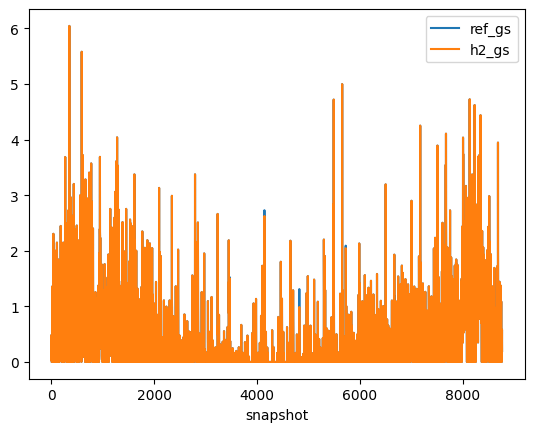

In [58]:
ref_gs = n_ref.generators_t.p.grid.sum()
h2_gs = n_h2.generators_t.p.grid.sum()
el_load = df_data['electric_load'].sum()

print("ref network grid supply: ", ref_gs)
print("h2 network grid supply: ", h2_gs)

res = pd.DataFrame()
res['ref_gs'] = n_ref.generators_t.p.grid
res['h2_gs'] = n_h2.generators_t.p.grid

res.plot()

In [59]:
n_ref.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
charge_bat,electricity,bat_bus,,AC,0.98,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,2.883646
discharge_bat,bat_bus,electricity,,AC,0.98,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,2.769454
housegrid_in,house_IO,electricity,,AC,1.00,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,6.170000
housegrid_out,electricity,house_IO,,AC,1.00,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.000000
wp,electricity,heat,,AC,1.00,0,inf,2.5,False,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,2.500000
charge_heat,heat,heat_storage_bus,,AC,0.95,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,9.305000
discharge_heat,heat_storage_bus,heat,,AC,0.95,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,5.073684


In [60]:
n_h2.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,bus2,efficiency2
Link,,,,,,,,,,,,,,,,,,,,,
charge_bat,electricity,bat_bus,,AC,0.980,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,62.759363,,0.0
discharge_bat,bat_bus,electricity,,AC,0.980,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,61.447657,,0.0
wp,electricity,heat,,AC,1.000,0,inf,2.5,False,0.0,...,0,1,0,NaN,NaN,1.0,1.0,2.500000,,0.0
charge_heat,heat,heat_storage_bus,,AC,0.950,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,67.045895,,0.0
discharge_heat,heat_storage_bus,heat,,AC,0.950,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,62.474626,,0.0
ely,electricity,h2_bus,,AC,0.625,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.000000,heat,0.2
fc,h2_bus,electricity,,AC,0.800,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.000000,heat,0.2


In [61]:
n_ref.stores

attribute,bus,type,carrier,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,...,e_cyclic_per_period,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
battery,bat_bus,,AC,0.0,True,1.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,0.0,71.360,0.02,0,inf,2.825973
heat_storage,heat_storage_bus,,AC,0.0,True,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,0.0,2.666,0.08,0,inf,15.237175


In [62]:
n_h2.stores

attribute,bus,type,carrier,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,...,e_cyclic_per_period,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
battery,bat_bus,,AC,2.825973,False,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,0.0,71.360,0.020,0,inf,2.825973
heat_storage,heat_storage_bus,,AC,15.237175,False,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,0.0,2.666,0.080,0,inf,15.237175
h2_storage,h2_bus,,AC,0.000000,True,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,0.0,1000.000,0.001,0,inf,0.000000


In [63]:
n_ref.stores_t.e.sum()

Store
battery          4595.552692
heat_storage    16251.695348
dtype: float64

In [64]:
results_ref = pd.DataFrame()
results_h2 = pd.DataFrame()
n_ref = build_ref_network()
n_h2 = build_h2_network()

for strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.4)): 
    print(strompreis_bezug)
    n_ref.generators.loc['grid', 'marginal_cost'] = strompreis_bezug 
    n_ref.optimize(solver_name = 'gurobi')
    
    n_h2.generators.loc['grid', 'marginal_cost'] = strompreis_bezug 
    n_h2.stores.loc['battery', 'e_nom'] = n_ref.stores.e_nom_opt.battery
    n_h2.stores.loc['heat_storage', 'e_nom'] = n_ref.stores.e_nom_opt.heat_storage
    n_h2.optimize(solver_name='gurobi')
    
    results_ref = results_ref.append(auswertungsfunktion(n_ref, strompreis_bezug ))
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, strompreis_bezug ))
    


1.08


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 29.50it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-w85zxluh.lp
Reading time = 0.59 seconds
obj: 271570 rows, 122650 columns, 516848 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 271570 rows, 122650 columns and 516848 nonzeros
Model fingerprint: 0x4c443149
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 8e+00]
Presolve removed 219042 rows and 43857 columns
Presolve time: 0.43s
Presolved: 52528 rows, 78793 columns, 175131 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 9.638e+04
 Factor NZ  : 5.746e+05 (roughly 60 MB of memory)
 Factor Ops : 7.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271570 duals
Objective: 2.63e+03
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 29.00it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-_y5u1il2.lp
Reading time = 0.69 seconds
obj: 280328 rows, 131408 columns, 543125 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 280328 rows, 131408 columns and 543125 nonzeros
Model fingerprint: 0x070b0bad
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [1e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 3e+01]
Presolve removed 210252 rows and 30711 columns
Presolve time: 0.33s
Presolved: 70076 rows, 100697 columns, 258362 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.664e+05
 Factor NZ  : 1.016e+06 (roughly 80 MB of memory)
 Factor Ops : 1

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131408 primals, 280328 duals
Objective: 2.53e+03
Solver model: available
Solver message: 2



0.68


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 34.52it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-z7l57n3v.lp
Reading time = 0.60 seconds
obj: 271570 rows, 122650 columns, 516848 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 271570 rows, 122650 columns and 516848 nonzeros
Model fingerprint: 0x6078db9a
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 8e+00]
Presolve removed 219042 rows and 43857 columns
Presolve time: 0.42s
Presolved: 52528 rows, 78793 columns, 175131 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 9.638e+04
 Factor NZ  : 5.746e+05 (roughly 60 MB of memory)
 Factor Ops : 7.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271570 duals
Objective: 1.66e+03
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 28.28it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-mg9ip7_s.lp
Reading time = 0.64 seconds
obj: 280328 rows, 131408 columns, 543125 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 280328 rows, 131408 columns and 543125 nonzeros
Model fingerprint: 0x85a67873
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 2e+01]
Presolve removed 210252 rows and 30711 columns
Presolve time: 0.31s
Presolved: 70076 rows, 100697 columns, 258362 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.664e+05
 Factor NZ  : 1.016e+06 (roughly 80 MB of memory)
 Factor Ops : 1

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131408 primals, 280328 duals
Objective: 1.72e+03
Solver model: available
Solver message: 2



0.28


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 30.29it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-q3beg4w3.lp
Reading time = 0.66 seconds
obj: 271570 rows, 122650 columns, 516848 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 271570 rows, 122650 columns and 516848 nonzeros
Model fingerprint: 0x3b05806b
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 8e+00]
Presolve removed 219042 rows and 43857 columns
Presolve time: 0.54s
Presolved: 52528 rows, 78793 columns, 175131 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 9.638e+04
 Factor NZ  : 5.746e+05 (roughly 60 MB of memory)
 Factor Ops : 7.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271570 duals
Objective: 5.08e+02
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 7/7 [00:00<00:00, 27.63it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-uxtlonyn.lp
Reading time = 0.63 seconds
obj: 280328 rows, 131408 columns, 543125 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 280328 rows, 131408 columns and 543125 nonzeros
Model fingerprint: 0x98e1921c
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [3e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 210252 rows and 30711 columns
Presolve time: 0.32s
Presolved: 70076 rows, 100697 columns, 258362 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.664e+05
 Factor NZ  : 1.016e+06 (roughly 80 MB of memory)
 Factor Ops : 1

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131408 primals, 280328 duals
Objective: 9.83e+02
Solver model: available
Solver message: 2



In [65]:
results_ref

,Kapital- und marginale kosten €/a,Verbrauchseinsparung €/a,Marginale Kosten €/a,Ursprüngliche Energiekosten €/a,Investitionskosten €/a,Einspeiseverguetung €/a,Amortisationsdauer a,Netzbezug kWh/a,Netzeinspeisung kWh/a,PV-Ertragssumme kWh/a,Einspeicherung kWh/a,Auspeicherung kWh/a,Pufferspeicherkapazität kWh,Batteriepeicherkapazität kWh,Leistung Wärmepumpe kW
1.08,9459.807202,3059.763807,2088.625755,5148.389562,7371.181447,-2231.789673,48.181376,2347.207120,5579.474182,10724.82,1949.120551,1667.084138,28.793525,6.461387,2.5
0.68,8491.594630,2575.191379,1251.597582,3826.788961,7239.997048,-2341.203641,56.228808,2529.173985,5853.009102,10724.82,1604.419084,1391.498173,22.534704,4.856869,2.5
0.28,7341.776852,2095.832958,409.355403,2505.188361,6932.421449,-2876.057080,66.154332,3516.310066,7190.142700,10724.82,381.601470,348.301523,10.400644,1.000000,2.5


In [66]:
results_h2

,Kapital- und marginale kosten €/a,Verbrauchseinsparung €/a,Marginale Kosten €/a,Ursprüngliche Energiekosten €/a,Investitionskosten €/a,Einspeiseverguetung €/a,Amortisationsdauer a,Netzbezug kWh/a,Netzeinspeisung kWh/a,PV-Ertragssumme kWh/a,Einspeicherung kWh/a,Auspeicherung kWh/a,Pufferspeicherkapazität kWh,Batteriepeicherkapazität kWh,Leistung Wärmepumpe kW
1.08,9904.546631,2615.024378,2533.365184,5148.389562,7371.181447,0,56.375623,2345.708504,0,7095.627194,7261.506654,6732.037726,28.793525,6.461387,2.5
0.68,8957.958987,2108.827023,1717.961939,3826.788961,7239.997048,0,68.663736,2526.414616,0,6306.478354,4579.940787,4207.136003,22.534704,4.856869,2.5
0.28,7915.375361,1522.234449,982.953912,2505.188361,6932.421449,0,91.082178,3510.549684,0,4214.198318,801.041311,727.221485,10.400644,1.000000,2.5


<AxesSubplot:xlabel='snapshot'>

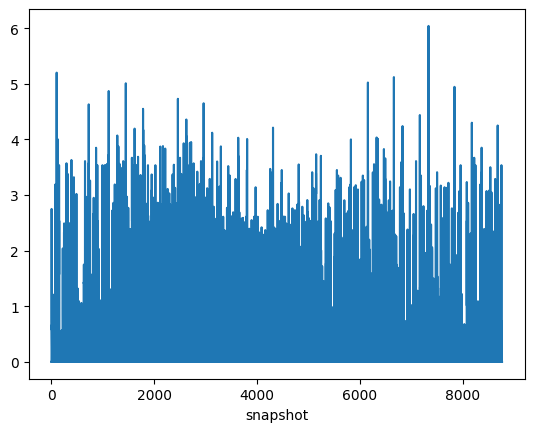

In [67]:
n_h2.generators_t.p.pv.plot()

<AxesSubplot:xlabel='snapshot'>

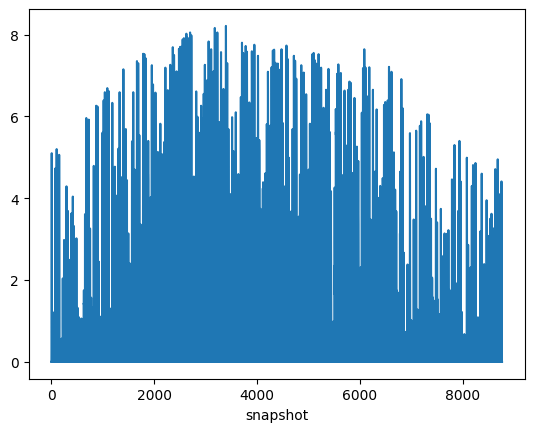

In [68]:
n_ref.generators_t.p.pv.plot()

In [69]:
n_h2.buses_t.p.plot(y='house_IO')

KeyError: 'house_IO'

In [ ]:
n_ref.generators.capital_cost.pv

In [ ]:
pv_params['capital_cost']

In [ ]:
#Anzahl der Diagramme, Achsenbeschriftung und Überschriften festlegen
# Call up of the function results, clearing of the results DF
results_ref.drop(results_ref.index, inplace=True)  
results_ref.index.name = 'Strompreis von 0,28 €/kWh bis 1,48 €kWh'
 

fig, axes = plt.subplots(nrows=4, ncols=4, figsize = (15,10))
results_ref.plot(subplots=True, ax=axes)

 

axes[0,0].set_ylabel('€/a') 
axes[0,1].set_ylabel('€/a')
axes[0,2].set_ylabel('€/a')
axes[0,3].set_ylabel('€/a')
axes[1,0].set_ylabel('€/a')
axes[1,1].set_ylabel('€/a') 
axes[1,2].set_ylabel('a')
axes[1,3].set_ylabel('kg/a')
axes[2,0].set_ylabel('kWh/a')                  
axes[2,1].set_ylabel('kWh/a')
axes[2,2].set_ylabel('kWh/a')
axes[2,3].set_ylabel('kWh/a')
axes[3,0].set_ylabel('kWh/a')
axes[3,1].set_ylabel('L')            
axes[3,2].set_ylabel('kWh')
axes[3,3].set_ylabel('kW')

 


axes[0,0].set_title('Kapital- und marginale kosten')
axes[0,1].set_title('Verbrauchseinsparung')
axes[0,2].set_title('Marginale Kosten')
axes[0,3].set_title('Ursprüngliche Energiekosten')
axes[1,0].set_title('Investitionskosten')
axes[1,1].set_title('Einspeiseverguetung')
axes[1,2].set_title('Amortisationsdauer')
axes[1,3].set_title('Gesamter Pelletverbrauch')
axes[2,0].set_title('Netzbezug')
axes[2,1].set_title('Netzeinspeisung')
axes[2,2].set_title('PV-Ertragssumme')
axes[2,3].set_title('Einspeicherung')
axes[3,0].set_title('Auspeicherung')
axes[3,1].set_title('Pufferspeicherkapazität')
axes[3,2].set_title('Batteriepeicherkapazität')
axes[3,3].set_title('Leistung BHKW')

 


fig.suptitle('Sensitivitätsanalyse des Pelletpreis')
fig.tight_layout()